In [1]:
from util import *
from dnc_lstm import DNC
from dnc_ff import DNCFF
from autograd import grad
from autograd.misc.optimizers import rmsprop, adam

In [2]:
def seq(seq_len, seq_width):
    """
    Implements the copy task - section 4.1 from the NTM paper.
    Returns inputs, outputs, and a mask for loss calculation
    """
    rand_tile = np.random.randint(2, size=(seq_len, seq_width))
    inputs = np.zeros((seq_len*2+3, seq_width+2))
    inputs[0,1] = 1
    inputs[seq_len+1,0] = 1
    inputs[1:seq_len+1, 2:] = rand_tile
    targets = np.zeros((seq_len*2+3, seq_width+1))
    targets[-1,0] = 1
    targets[seq_len+2:-1, 1:] = rand_tile
    mask = np.zeros((seq_len*2+3, seq_width+1))
    mask[seq_len+2:,:] = 1
    return inputs, targets, mask

inputs, targets, mask = seq(4, 4)
print inputs
print targets
print mask

[[ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.]
 [ 0.  0.  1.  1.  1.  1.]
 [ 0.  0.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  1.  0.  1.  0.]
 [ 0.  1.  1.  1.  1.]
 [ 0.  1.  0.  1.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]


Training DNC...
('Iteration', 0, 'Train loss:', 0.31640451929249264)
Test loss:  0.31509997941
Param Mag:  0.00132484061027
Input


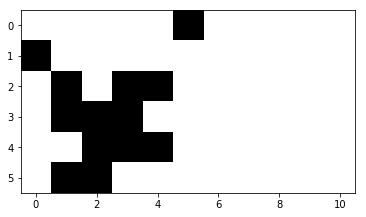

Target


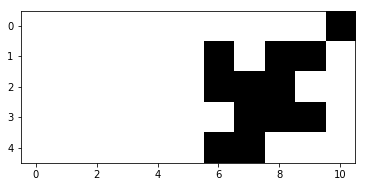

Predicted


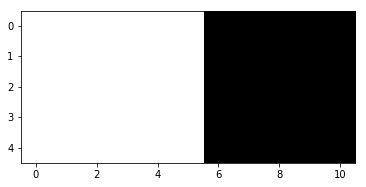

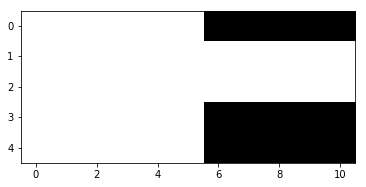

('Iteration', 1000, 'Train loss:', 0.25110652362948943)
Test loss:  0.265048365061
Param Mag:  0.0023496558488
Input


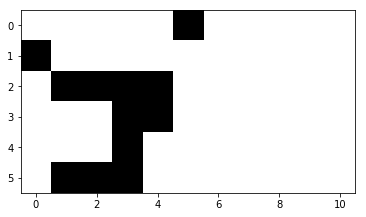

Target


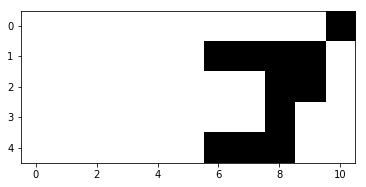

Predicted


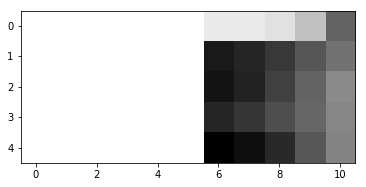

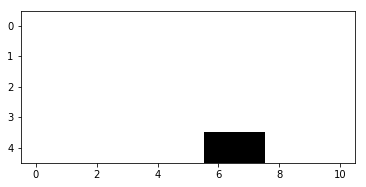

('Iteration', 2000, 'Train loss:', 0.24461289949830517)
Test loss:  0.220640859982
Param Mag:  0.00225904428887
Input


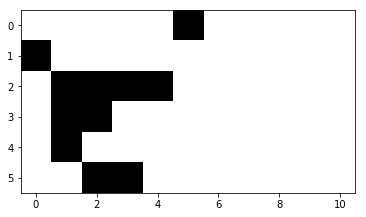

Target


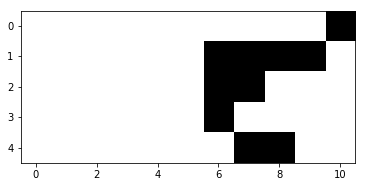

Predicted


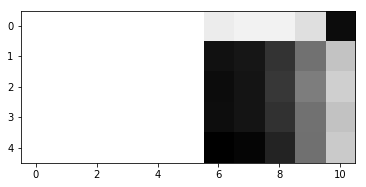

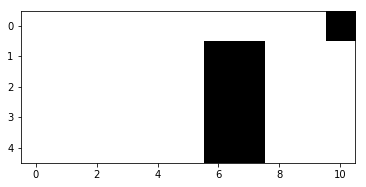

('Iteration', 3000, 'Train loss:', 0.23327591561736472)
Test loss:  0.20770292042
Param Mag:  0.00221440332447
Input


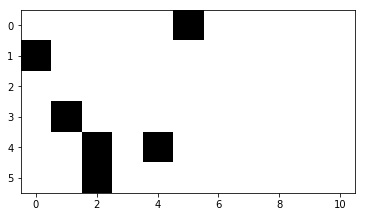

Target


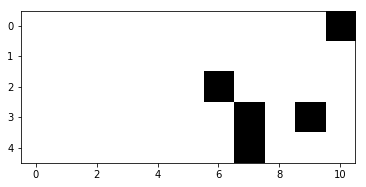

Predicted


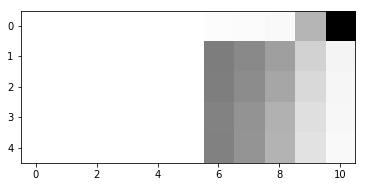

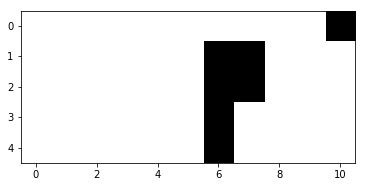

('Iteration', 4000, 'Train loss:', 0.20606151493412272)
Test loss:  0.217650747043
Param Mag:  0.00218780648953
Input


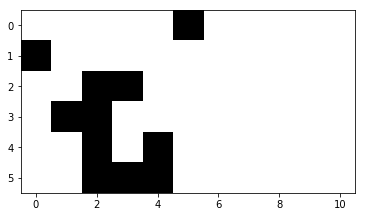

Target


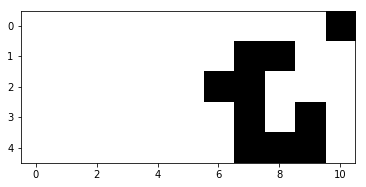

Predicted


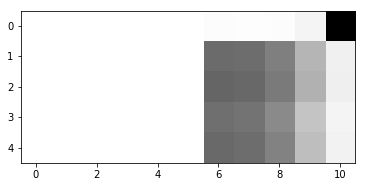

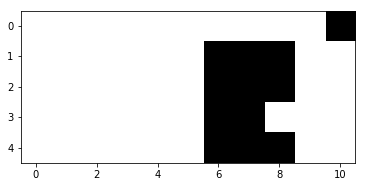

In [ ]:
def loss_fn(pred, target, mask):
    pred = sigmoid(pred)
    one = np.ones_like(pred)
    epsilon = 1.e-20 # to prevent log(0)
    a = target * np.log(pred + epsilon)
    b = (one - target) * np.log(one - pred + epsilon)
    return np.mean(- (a + b) * mask)

# def loss_fn(pred, target, mask):
#     pred = sigmoid(pred)
#     l2 = np.sqrt(np.square(pred - target))
#     return np.mean(l2 * mask)

def l2(x):
    """
    stable l2-norm
    """
    return np.sqrt(np.sum(np.multiply(x, x)) + 1.e-20) 

seq_len, seq_wid = 4, 4
# inputs, targets, mask = seq(seq_len, seq_wid)
# inputs = np.loadtxt('weights%d/in.csv'%wset, delimiter=',')
# targets = np.loadtxt('weights%d/target.csv'%wset, delimiter=',')
# mask = np.ones_like(targets)
# dnc = DNCFF(input_size=4, output_size=4, hidden_size=32, R=1, N=10, W=4)

dnc = DNCFF(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=1, N=10, W=4)
# dnc = DNC(input_size=12, output_size=10, hidden_size=10, R=1, N=10, W=1)
dnc_params = dnc._init_params()
# for k,v in dnc_params.items():
#     print k
#     print v.shape

def print_training_prediction(params, iters):
    
    inputs, targets, mask = seq(seq_len, seq_wid)
    result = []
#     dnc = DNCFF(input_size=4, output_size=4, hidden_size=32, R=1, N=10, W=4)
    dnc = DNCFF(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=1, N=10, W=4)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
    loss = loss_fn(result, targets, mask)
    print "Test loss: ", loss
    reg = l2(params['W_1']) + l2(params['W_2']) + l2(params['b_1']) + l2(params['b_2'])
    print "Param Mag: ", 5e-4 * reg
    print "Input"
    display(inputs.T)
    print "Target"
    display(targets.T)
    print "Predicted"
    display((sigmoid(result) * mask).T)
    display(np.around((sigmoid(result) * mask), decimals=0).astype('int').T)
    
    # Saving Model Check Points
    save_pickle(params, './ckpt_rmsprop/Iter_%d_Loss_%.6f_Reg_%.6f.pkl' % (iters, loss, reg))

    
def training_loss(params, iters):
    inputs, targets, mask = seq(seq_len, seq_wid)
    result = []
#     dnc = DNCFF(input_size=4, output_size=4, hidden_size=32, R=1, N=10, W=4)
    dnc = DNCFF(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=1, N=10, W=4)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
    # regularization
    reg = l2(params['W_1']) + l2(params['W_2']) + l2(params['b_1']) + l2(params['b_2'])
    return loss_fn(result, targets, mask) + 5.e-4 * reg

def callback(weights, iters, gradient):
    if iters % 1000 == 0:
        print("Iteration", iters, "Train loss:", training_loss(weights, 0))
        print_training_prediction(weights, iters)

# Build gradient of loss function using autograd.
training_loss_grad = grad(training_loss)

print("Training DNC...")
# trained_params = adam(training_loss_grad, dnc_params, step_size=0.001,
#                       num_iters=1000000, callback=callback)
trained_params = rmsprop(training_loss_grad, dnc_params, step_size=0.001,
                      num_iters=1000000, callback=callback)






In [13]:
# Test simple ff network

xor_params = {
    'W_1':nprn(2,4),
    'W_2':nprn(4,1),
    'b_1':np.zeros((1,4)),
    'b_2':np.zeros((1,1)),
}

dataset = [[0,0],[0,1],[1,0],[1,1]]
dataset = np.array(dataset)
targets = np.array([0,1,1,0])

def feedforward(params, x_t):
    h_1 = np.dot(x_t, params['W_1']) + params['b_1']
    h_1 = sigmoid(h_1)
    o_1 = np.dot(h_1, params['W_2']) + params['b_2']
    o_1 = sigmoid(o_1)
    return o_1

def loss_fn(out, target):
    return np.sqrt(np.square(out-target))

def print_training_prediction(params):
    for row in dataset:
        out = feedforward(params, row[np.newaxis, :])
        print row, out

def training_loss(params, iter):
    loss = 0
    for idx, row in enumerate(dataset):
        out = feedforward(params, row[np.newaxis, :])
        loss = loss + loss_fn(out, targets[idx])
    return loss

def callback(weights, iter, gradient):
    if iter % 500 == 0:
        print("Iteration", iter, "Train loss:", training_loss(weights, 0))
        print_training_prediction(weights)

# Build gradient of loss function using autograd.
training_loss_grad = grad(training_loss)

print("Training XOR...")
# trained_params = adam(training_loss_grad, dnc_params, step_size=0.001,
#                       num_iters=1000, callback=callback)
trained_params = rmsprop(training_loss_grad, xor_params, step_size=0.001,
                      num_iters=10000, callback=callback)

Training XOR...
('Iteration', 0, 'Train loss:', array([[ 2.01487063]]))
[0 0] [[ 0.71557645]]
[0 1] [[ 0.60522889]]
[1 0] [[ 0.69249639]]
[1 1] [[ 0.59701946]]
('Iteration', 500, 'Train loss:', array([[ 1.96612337]]))
[0 0] [[ 0.79146216]]
[0 1] [[ 0.65700888]]
[1 0] [[ 0.7520248]]
[1 1] [[ 0.5836949]]
('Iteration', 1000, 'Train loss:', array([[ 1.83970027]]))
[0 0] [[ 0.89554105]]
[0 1] [[ 0.74378713]]
[1 0] [[ 0.80737705]]
[1 1] [[ 0.49532341]]
('Iteration', 1500, 'Train loss:', array([[ 1.63490696]]))
[0 0] [[ 0.94987146]]
[0 1] [[ 0.81457041]]
[1 0] [[ 0.85323575]]
[1 1] [[ 0.35284166]]
('Iteration', 2000, 'Train loss:', array([[ 1.4160493]]))
[0 0] [[ 0.97353951]]
[0 1] [[ 0.88597569]]
[1 0] [[ 0.89153614]]
[1 1] [[ 0.22002161]]
('Iteration', 2500, 'Train loss:', array([[ 1.2383719]]))
[0 0] [[ 0.98170177]]
[0 1] [[ 0.93012724]]
[1 0] [[ 0.93532511]]
[1 1] [[ 0.12212249]]
('Iteration', 3000, 'Train loss:', array([[ 1.11994352]]))
[0 0] [[ 0.98388553]]
[0 1] [[ 0.96007301]]
[1 0] [

In [4]:
from util import *

class DNCAccessorDebug(object):
    """
    DNC Accessor, using autodiff, with batchsize=1
    """

    def __init__(self, R, N, W):

        self.R = R  # number of read heads
        self.N = N  # number of memory locations
        self.W = W  # number of columns in a memory location
         
        self._init_state()
        
    def _init_state(self):
        state = {}
        # linkage matrix
        state['L'] = np.zeros((self.N, self.N))
        # read_weighting
        state['rw'] = np.ones((self.R, self.N))*1e-6
        # precedence_weighting
        state['p'] = np.zeros((1, self.N))
        # write_weighting
        state['ww'] = np.ones((1, self.N))*1e-6
        # usage_vector
        state['u'] = np.ones((1, self.N))*1e-6
        self.states = [state]
    
    def process_interface(self, interface):
        """
        Parse and process the input interface vector
        interface      - 1x(W*R+3W+5R+3) interface vector

        Return:
        rk_t         - RxW read keys
        rs_t         - Rx1 read strength
        wk_t         - 1xW write key
        ws_t         - 1x1 write strength
        e_t          - 1xW erase vector
        v_t          - 1xW write vector
        f_t          - Rx1 free gates
        ga_t         - 1x1 allocation gate
        gw_t         - 1x1 write gate
        pi_t         - Rx3 read modes
        """
        section_index = np.cumsum([self.R*self.W, self.R, self.W, 1, self.W, self.W, self.R, 1, 1, self.R*3])
        rk_t, rs_t, wk_t, ws_t, e_t, v_t, f_t, ga_t, gw_t, pi_t = np.split(interface, section_index[:-1], axis=1)
        rk_t = rk_t.reshape(self.R, self.W)
        rs_t = oneplus(rs_t.reshape(self.R, 1))
        wk_t = wk_t.reshape(1, self.W)
        ws_t = oneplus(ws_t)
        e_t = sigmoid(e_t.reshape(1, self.W))
        v_t = v_t.reshape(1, self.W)
        f_t = sigmoid(f_t.reshape(self.R, 1))
        ga_t = sigmoid(ga_t)
        gw_t = sigmoid(gw_t)
        pi_t = softmax(pi_t.reshape(3, self.R)).T # be careful to calculate softmax along the correct dim (read heads), want to double check this
        return rk_t, rs_t, wk_t, ws_t, e_t, v_t, f_t, ga_t, gw_t, pi_t  
        
    def content_weighting(self, mem, ks, betas):
        """
        The content based addressing method
        mem   - NxW memory     (N locations,  W entries)
        ks    - RxW lookup key (R heads, W entries)
        betas - 1xR lookup strength

        Return:
        RxN addressing matrix
        """
#         if len(ks.shape) < 2: ks = ks[np.newaxis, :] # deal with write head

        # Cosine Similarity
        n = np.dot(ks, mem.T)
        # einsum is fast: https://stackoverflow.com/questions/15616742/vectorized-way-of-calculating-row-wise-dot-product-two-matrices-with-scipy
        ks_inner_prod = np.einsum('ij,ij->i', ks, ks) + 1.e-20
        mem_inner_prod = np.einsum('ij,ij->i', mem, mem) + 1.e-20
        d = np.sqrt(np.einsum('i,j->ij', ks_inner_prod, mem_inner_prod)) # + 1.e-20 # prevent undefined cos similarity at 0 from breaking the code
        sim = betas * (n / d)
        
        return softmax(sim)
    
    def usage_vec(self, f_t, rw_prev, ww_prev, u_prev):
        """
        Update usage vector
        f_t           - Rx1 free gates
        rw_prev       - RxN previous read weightings (R read heads, N locations)
        ww_prev       - 1xN previous write weighting (R read heads, 1 location)
        u_prev        - 1xN previous usage vector

        Return:
        1xN new usage vector
        """
        # psi is the 1xN retention vector
        psi = np.ones_like(rw_prev) - f_t * rw_prev
        psi = np.prod(psi, axis=0)
        # u is the usage vector
        u = (u_prev + ww_prev - u_prev * ww_prev) * psi
        return psi, u

    def allocation_weighting(self, u):
        """
        Dynamic memory allocation weighting mechanism
        u_prev        - 1xN current usage vector

        Return:
        1xN alloc_weighting
        """
        # phi is the indices list that would sort u in ascending order
        phi = np.argsort(u, axis=1).squeeze()
        inverse_perm = np.argsort(phi)
        
        # double check if this is differentiable
        sorted_alloc = (np.ones_like(u) - u[:,phi]) * shift_cumprod(u[:,phi])
        alloc_weighting = sorted_alloc[:,inverse_perm]
        return alloc_weighting

    def write_weighting(self, M_prev, wk_t, ws_t, u, gw_t, ga_t):
        """
        Write Weighting Mechanism
        
        M_prev        - NxW previous memory state
        wk_t          - 1xW write key
        ws_t          - 1x1 write strength
        f_t           - Rx1 free gates
        u             - 1xN current usage vector
        gw_t          - 1x1 write gate
        ga_t          - 1x1 allocation gate

        Return:
        1xN write_weighting 
        """
        c = self.content_weighting(M_prev, wk_t, ws_t)
        a = self.allocation_weighting(u)
        
        # hard coded this for debug purpose
        a = np.array(
            [[ 0.99999797,
              0.99999797,
              0.99999797,
              0.99999797,
              0.99999797,
              0.99999797,
              0.99999797,
              0.99999797,
              0.99999797,
              0.99999797]]
        )
        return a, c, gw_t * (ga_t * a + (1. - ga_t) * c)
        
    def temporal_memory_linkage(self, p_prev, ww, L_prev):
        """
        Temporal Linkage (TODO: Implement sparse link matrix)
        
        p_prev     - 1xN precedence weighting from last time step
        w_w        - 1xN write weighting
        L_prev     - NxN link matrix
        
        Return:
        1xN current precedence weighting
        NxN link matrix
        """
        # precedence weighting of the current timestep
        p_t = (1. - np.sum(ww)) * p_prev + ww
        L_t = (np.ones_like(L_prev) - (ww + ww.T)) * L_prev + ww.T * p_prev
        # Sanity check diag(L_t) should always be zero
        L_t = L_t - np.diag(np.diag(L_t))
        
        return p_t, L_t
    
    def read_weighting(self, M, rk_t, rs_t, rw_prev, L, pi_t):
        """
        Read Weighting
        
        M          - NxW memory matrix from current time step
        rk_t       - RxW read keys
        rs_t       - 1xR read strengths
        rw_prev    - RxN read weighting from previous time step
        L          - NxN link matrix from current time step
        pi_t       - Rx3 read modes
        
        Return:
        RxN Read Weighting
        """
        # content weighting
        c = self.content_weighting(M, rk_t, rs_t)
        # forward weighting
        f_t = np.dot(rw_prev, L)
        # backward weighting
        b_t = np.dot(rw_prev, L.T)
        # interpolates using read modes
        read_weighting = pi_t[:,0,np.newaxis] * b_t + pi_t[:,1,np.newaxis] * c + pi_t[:,2,np.newaxis] * f_t
        return read_weighting
    
    def read(self, M, rw):
        """
        Read from memory
        
        M          - NxW memory matrix from current time step
        rw         - RxN read weighting
        
        Return:
        RxW Stacked Read Vectors
        """
        return np.dot(rw, M)
    
    def write(self, M, e_t, v_t, ww):
        """
        Write to memory
        
        M          - NxW memory matrix from current time step
        e_t        - 1xW erase vector
        v_t        - 1xW write vector
        ww         - 1xN write weighting
        
        Return:
        NxW updated memory
        """
        return (np.ones_like(M) - np.dot(ww.T, e_t)) * M + np.dot(ww.T, v_t)
    
    def step_forward(self, M_prev, interface):
        """
        Forward inference given a inference vector and previous memory state
        M_prev         - NxW previous memory state
        interface      - 1x(W*R+3W+5R+3) interface vector
        
        Return:
        RxW Stacked Read Vectors
        """
        rk_t, rs_t, wk_t, ws_t, e_t, v_t, f_t, ga_t, gw_t, pi_t = self.process_interface(interface)
        _s = self.states[-1] # previous state
        L_prev, rw_prev, p_prev, ww_prev, u_prev = _s['L'], _s['rw'], _s['p'], _s['ww'], _s['u']
        
        psi, u = self.usage_vec(f_t, rw_prev, ww_prev, u_prev)

        alloc_weights, write_lookup_weights, ww = self.write_weighting(M_prev, wk_t, ws_t, u, gw_t, ga_t)
        M = self.write(M_prev, e_t, v_t, ww)
        p, L = self.temporal_memory_linkage(p_prev, ww, L_prev)

        rw = self.read_weighting(M, rk_t, rs_t, rw_prev, L, pi_t)
        
        self.states.append(dict(zip(['u', 'ww', 'p', 'L', 'rw'],[u, ww, p, L, rw])))
        
        read_vec = self.read(M, rw)
#         return M, read_vec
    
        return [
            rk_t, rs_t, wk_t, ws_t,
            e_t, v_t, f_t, ga_t, gw_t,    
            pi_t, 
            psi, u, alloc_weights, write_lookup_weights,
            ww, M, L, p,
            rw, read_vec
        ]


class DNCFFDebug(object):
    """
    DNC with feedforward controller, using autodiff, with batchsize=1
    """

    def __init__(self, input_size, output_size, hidden_size, R, N, W):

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.R = R
        self.N = N  # the number of memory locations
        self.W = W # the number of columns in a memory location
        
        self.accessor = DNCAccessorDebug(R, N, W)
        self.states = None

    def _init_params(self):
        p = {} # maps parameter names to tensors
        
        # two layer feedforward weights
        p['W_1'] = nprn(self.input_size + self.R * self.W, self.hidden_size)*0.1
        p['b_1'] = np.zeros((1, self.hidden_size))
        p['W_2'] = nprn(self.hidden_size, self.output_size)*0.1
        p['b_2'] = np.zeros((1, self.output_size))
        
        p['W_y'] = nprn(self.output_size, self.output_size)*0.1
        p['W_xi'] = nprn(self.output_size, self.R*self.W + 3*self.W + 5*self.R + 3)*0.1
        
        # output weights
        p['W_r'] = nprn(self.R*self.W, self.output_size)*0.1
        return p
    
    def _init_state(self):
        state = {}
        # not initializing to zero can prevent nan in loss
        # memory matrix
        state['M'] = np.zeros((self.N, self.W)) 
        # read vector
        state['rv'] = np.ones((self.R, self.W))*1e-6
        self.states = [state]
    
    def nn_step_forward(self, params, x_t, rv_prev):
        """
        nn step forward

        x_t        - 1xX input
        rv_prev    - RxW read vector from prev step
        params     - lstm parameter dictionary, included here for the purpose of backprop

        Return:
        v_t        - 1xY output vector
        interface  - 1x(W*R+3W+5R+3) interface vector
        """
        X_t = np.concatenate((x_t, rv_prev.reshape(1,-1)), axis=1)
        h_1 = np.dot(X_t, params['W_1']) + params['b_1']
        h_1 = np.tanh(h_1)
        o_1 = np.dot(h_1, params['W_2']) + params['b_2']
        o_1 = np.tanh(o_1)

        v_t = np.dot(o_1, params['W_y'])
        interface = np.dot(o_1, params['W_xi'])
        return v_t, interface
    
    def step_forward(self, params, x_t):
        if self.states is None: self._init_state()
        
        _s = self.states[-1]
        M_prev, rv_prev = _s['M'], _s['rv']
        
        v_t, interface = self.nn_step_forward(params, x_t, rv_prev)
        
        
        [
            rk_t, rs_t, wk_t, ws_t,
            e_t, write_vec, f_t, alloc_gate, write_gate, read_modes, 
            retention_vec, usage_vec, alloc_weights, write_lookup_weights,
            write_weights, M_t, link_mat, precedence_weight,
            read_weights, rv_t
        ] = self.accessor.step_forward(M_prev, interface)
        
#         M_t, rv_t = self.accessor.step_forward(M_prev, interface)
        state = dict(zip(['M', 'rv'], [M_t, rv_t]))
        self.states.append(state)
        
        out = v_t + np.dot(rv_t.reshape(1,-1), params['W_r'])
        
        return [
            v_t, interface, rk_t, rs_t, wk_t, ws_t,
            e_t, write_vec, f_t, alloc_gate, write_gate, read_modes, 
            retention_vec, usage_vec, alloc_weights, write_lookup_weights,
            write_weights, M_t, link_mat, precedence_weight,
            read_weights, rv_t, np.dot(rv_t.reshape(1,-1), params['W_r']), out
        ]

dnc = DNCFFDebug(input_size=4, output_size=4, hidden_size=32, R=1, N=10, W=4)
wset = 4
dnc_params = {
    'W_2':np.loadtxt('weights%d/W2.csv'%wset, delimiter=','),
    'W_1':np.loadtxt('weights%d/W1.csv'%wset, delimiter=','),
    'b_1':np.loadtxt('weights%d/b1.csv'%wset, delimiter=','),
    'b_2':np.loadtxt('weights%d/b2.csv'%wset, delimiter=','),
    'W_y':np.loadtxt('weights%d/nn_out.csv'%wset, delimiter=','),
    'W_xi':np.loadtxt('weights%d/interface.csv'%wset, delimiter=','),
    'W_r':np.loadtxt('weights%d/readvec.csv'%wset, delimiter=',')
}
inputs = np.loadtxt('weights%d/in.csv'%wset, delimiter=',')
targets = np.loadtxt('weights%d/target.csv'%wset, delimiter=',')
predictions = np.loadtxt('weights%d/pred.csv'%wset, delimiter=',')

def print_training_prediction(params):
    
    result = []
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
#     result = np.concatenate(result, axis=0)
    print len(result)
    print len(result[0])
    print len(result[0][0])
    return result
#     print 'Input'
#     display(inputs.T)
#     print "Target"
#     display(targets.T)
#     print "Target Prediction"
#     display(np.around(sigmoid(predictions), decimals=0).astype('int').T)
#     print "Predicted"
#     print result
#     display(np.around(sigmoid(result), decimals=0).astype('int').T)

param_names = [
    'v_t', 'interface_vec', 'rk_t', 'rs_t', 'wk_t', 'ws_t',
    'e_t', 'write_vec', 'f_t', 'alloc_gate', 'write_gate', 'read_modes', 
    'retention_vec', 'usage_vec', 'alloc_weights', 'write_lookup_weights',
    'write_weights', 'mem_mat', 'link_mat', 'precedence_weight',
    'read_weights', 'read_vecs', 'read_vec_mut', 'result'
]   
exp_res = print_training_prediction(dnc_params)

target_results = np.load('weights%d/interm.npy'%wset)
[
    v_t, interface_vec, rk_t, rs_t, wk_t, ws_t,
    e_t, write_vec, f_t, alloc_gate, write_gate, read_modes, 
    retention_vec, usage_vec, alloc_weights, write_lookup_weights,
    write_weights, mem_mat, link_mat, precedence_weight,
    read_weights, read_vecs, read_vec_mut, result
] = target_results[0]

for i in range(12):
    for j in range(24):
        print "Iteration: %d %s"%(i,param_names[j])
        print "Is close: ", np.allclose(exp_res[i][j], target_results[i][j])
        print "exp shape: ", exp_res[i][j].shape, "; target shape: ", target_results[i][j].shape
        print exp_res[i][j]#.shape
        print target_results[i][j]#.shape

12
24
1
Iteration: 0 v_t
Is close:  True
exp shape:  (1, 4) ; target shape:  (1, 4)
[[ -4.80624972  -6.96264501 -10.76622933 -15.10950181]]
[[ -4.80624914  -6.96264553 -10.76622963 -15.10950089]]
Iteration: 0 interface_vec
Is close:  True
exp shape:  (1, 24) ; target shape:  (1, 24)
[[-0.27728384  0.40165089 -0.46941661  0.40258977  0.05226667 -0.58946567
   0.05757373 -0.22797507 -0.32457899 -0.5003318  -1.16118783 -0.06038912
  -3.44850481 -2.95298714 -3.12136549 -2.50128951 -1.02962347 -2.30233521
   3.20241566 -0.32467744 -0.09413458 -0.72748264  0.22004475  0.16605995]]
[[-0.27728382  0.40165088 -0.46941668  0.40258974  0.05226668 -0.58946568
   0.05757375 -0.22797507 -0.324579   -0.50033182 -1.16118753 -0.06038921
  -3.44850445 -2.95298719 -3.12136579 -2.50128937 -1.02962339 -2.30233526
   3.2024157  -0.32467747 -0.09413455 -0.72748268  0.22004473  0.16605993]]
Iteration: 0 rk_t
Is close:  True
exp shape:  (1, 4) ; target shape:  (1, 4)
[[-0.27728384  0.40165089 -0.46941661  0.40

   0.35453841  0.35453841  0.35453841  0.35453841]]
Iteration: 3 alloc_weights
Is close:  False
exp shape:  (1, 10) ; target shape:  (10, 1)
[[ 0.99999797  0.99999797  0.99999797  0.99999797  0.99999797  0.99999797
   0.99999797  0.99999797  0.99999797  0.99999797]]
[[ 0.64546156]
 [ 0.64546156]
 [ 0.64546156]
 [ 0.64546156]
 [ 0.64546156]
 [ 0.64546156]
 [ 0.64546156]
 [ 0.64546156]
 [ 0.64546156]
 [ 0.64546156]]
Iteration: 3 write_lookup_weights
Is close:  True
exp shape:  (1, 10) ; target shape:  (10, 1)
[[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]]
[[ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]
 [ 0.1]]
Iteration: 3 write_weights
Is close:  False
exp shape:  (1, 10) ; target shape:  (10, 1)
[[ 0.27392775  0.27392775  0.27392775  0.27392775  0.27392775  0.27392775
   0.27392775  0.27392775  0.27392775  0.27392775]]
[[ 0.18807867]
 [ 0.18807867]
 [ 0.18807867]
 [ 0.18807867]
 [ 0.18807867]
 [ 0.18807867]
 [ 0.18807867]
 [ 0.18807867]
 [ 0.18807867]
 [

[[ 1.  1.  1.]]
[[ 1.]
 [ 1.]
 [ 1.]]
Iteration: 6 retention_vec
Is close:  False
exp shape:  (10,) ; target shape:  (10,)
[ 1.12598186  1.12598186  1.12598186  1.12598186  1.12598186  1.12598186
  1.12598186  1.12598186  1.12598186  1.12598186]
[ 0.70252407  0.70252407  0.70252407  0.70252407  0.70252407  0.70252407
  0.70252407  0.70252407  0.70252407  0.70252407]
Iteration: 6 usage_vec
Is close:  False
exp shape:  (1, 10) ; target shape:  (10, 10)
[[ 0.86137694  0.86137694  0.86137694  0.86137694  0.86137694  0.86137694
   0.86137694  0.86137694  0.86137694  0.86137694]]
[[ 0.34656554  0.34656554  0.34656554  0.34656554  0.34656554  0.34656554
   0.34656554  0.34656554  0.34656554  0.34656554]
 [ 0.34656554  0.34656554  0.34656554  0.34656554  0.34656554  0.34656554
   0.34656554  0.34656554  0.34656554  0.34656554]
 [ 0.34656554  0.34656554  0.34656554  0.34656554  0.34656554  0.34656554
   0.34656554  0.34656554  0.34656554  0.34656554]
 [ 0.34656554  0.34656554  0.34656554  0.346

 [ 0.1]]
Iteration: 9 write_weights
Is close:  False
exp shape:  (1, 10) ; target shape:  (10, 1)
[[ 0.31053848  0.31053848  0.31053848  0.31053848  0.31053848  0.31053848
   0.31053848  0.31053848  0.31053848  0.31053848]]
[[ 0.03618077]
 [ 0.03618077]
 [ 0.03618077]
 [ 0.03618077]
 [ 0.03618077]
 [ 0.03618077]
 [ 0.03618077]
 [ 0.03618077]
 [ 0.03618077]
 [ 0.03618077]]
Iteration: 9 mem_mat
Is close:  False
exp shape:  (10, 4) ; target shape:  (10, 4)
[[-4.18387806 -2.65102187 -1.99733545 -4.04609816]
 [-4.18387806 -2.65102187 -1.99733545 -4.04609816]
 [-4.18387806 -2.65102187 -1.99733545 -4.04609816]
 [-4.18387806 -2.65102187 -1.99733545 -4.04609816]
 [-4.18387806 -2.65102187 -1.99733545 -4.04609816]
 [-4.18387806 -2.65102187 -1.99733545 -4.04609816]
 [-4.18387806 -2.65102187 -1.99733545 -4.04609816]
 [-4.18387806 -2.65102187 -1.99733545 -4.04609816]
 [-4.18387806 -2.65102187 -1.99733545 -4.04609816]
 [-4.18387806 -2.65102187 -1.99733545 -4.04609816]]
[[-2.78850794  1.79977965 -4.14

In [27]:
def allocation_weighting(u):
    """
    Dynamic memory allocation weighting mechanism
    u_prev        - 1xN current usage vector

    Return:
    1xN alloc_weighting
    """
    # phi is the indices list that would sort u in ascending order
    phi = np.argsort(u, axis=0).squeeze()
    print phi
    inverse_perm = np.argsort(phi)

    # double check if this is differentiable
    sorted_alloc = (np.ones_like(u) - u[:,phi]) * shift_cumprod(u[:,phi])
    alloc_weighting = sorted_alloc[:,inverse_perm]
    return alloc_weighting

u = np.array([[  1.99999708e-06,   1.99999708e-06,   1.99999708e-06 ,  1.99999708e-06,
    1.99999708e-06,   1.99999708e-06,   1.99999708e-06,   1.99999708e-06,
    1.99999708e-06,   1.99999708e-06]])

u = np.array([[0.1, 0.1, 0.1, 0.1, 0.1]])

print allocation_weighting(u)

[0 0 0 0 0]
[[  9.00000000e-01   9.00000000e-02   9.00000000e-03   9.00000000e-04
    9.00000000e-05]]


In [26]:
print (1-1.99999727e-06)
print 1-0.99999797


0.999998000003
2.02999999999e-06
